# Binary classification of images

## Problem description:##

Our goal is to transform the multi-class classification problem (using famous MNIST dataset) into a binary. For this purpose, we combine 2 original MNIST images (digits, size =28x28) into one, after that each images contains 2 digits (new size = 56x28). So now we want to teach the neural network to find images that contain the number 4 (class=1, other images: class=0). 

In [162]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

import numpy as np
import random
from matplotlib import pyplot as plt
from PIL import Image

# the following line is not required if Dataset is installed as a python package.
sys.path.append("../..")
from dataset import Pipeline, B, C, F, V
import mnist
from dataset.models.tf import ResNet18
from dataset import DatasetIndex, Dataset, Batch

from dataset import B, V, F, R, P, action, ImagesBatch
from dataset.models.tf import TFModel
from dataset.models.tf.layers import conv_block
from dataset.batch_image import transform_actions

from dataset.opensets import MNIST

---------------------------------------------------------------------------------------------


#### Define Batch class which holds data and contains processing functions ####
**(in our case we can choose any default class like ImagesBatch)** 

In [182]:
@transform_actions(prefix='_', suffix='_', wrapper='apply_transform')
class MnistBatch(ImagesBatch):
    components = 'images', 'labels'

    def _shift_flattened_(self, image, max_margin=8):
        padded = np.pad(self._to_array_(image),
                        pad_width=[[max_margin, max_margin], [max_margin, max_margin], [0, 0]],
                        mode='minimum')
        left_lower = np.random.randint(2 * max_margin, size=2)
        slicing = (slice(left_lower[0], left_lower[0] + 28),
                   slice(left_lower[1], left_lower[1] + 28))
        return self._to_pil_(padded[slicing])

---------------------------------------------------------------------------------------------

#### Let's load data and create the dataset using MNIST openset: ####

In [164]:
dataset=MNIST(batch_class=MnistBatch)

Extracting /var/folders/ns/3lqd0mjj7vg1pt0gj5ph0nw80000gn/T/train-labels-idx1-ubyte.gz
Extracting /var/folders/ns/3lqd0mjj7vg1pt0gj5ph0nw80000gn/T/t10k-labels-idx1-ubyte.gz
Extracting /var/folders/ns/3lqd0mjj7vg1pt0gj5ph0nw80000gn/T/train-images-idx3-ubyte.gz
Extracting /var/folders/ns/3lqd0mjj7vg1pt0gj5ph0nw80000gn/T/t10k-images-idx3-ubyte.gz






  6%|▌         | 1/18 [32:56<9:20:07, 1976.93s/it]




  6%|▌         | 1/18 [23:59<6:47:43, 1439.02s/it]






  6%|▌         | 1/18 [10:52<3:04:50, 652.36s/it]


***Images and their labels are in preloaded.***

In [165]:
# odt = original data
odt=dataset.train.preloaded

***So "odt[0]" corresponds to a set of images and "odt[1]" corresponds to the list of labels***

---------------------------------------------------------------------------------------------

#### Sample pictures from the MNIST dataset: ####
![MNIST dataset](https://m-alcu.github.io/assets/mnist.png)  

---------------------------------------------------------------------------------------------

#### Create two lists - "four" and "others". #### 
**List "four" contains the indices of images of figure 4, list "others" - all the remaining indices**

In [166]:
four=[]
others=[]
for i in range(0, len(odt[1])):
    if odt[1][i]==4:
        four.append(i)
    else:
        others.append(i)
random.shuffle(others)

#### Create new images array (train_4), which contain images with number 4#####
**Also create labels array y_4 (all elements have class=1)**

In [167]:
# new_image_size 56 x 28
train_4 = odt[0][four[0]]
train_4 = np.append(train_4, odt[0][others[0]],axis=0)
zipped = zip(four, others[0:len(four)])
for i,j in zipped:
    if i != four[0]:
        train_4 = np.append(train_4, odt[0][i], axis=0)
        train_4 = np.append(train_4, odt[0][j], axis=0)
train_4 = train_4.reshape((len(four),56,28))
y_4 = np.ones((len(four)))

#### Create new images array (train_others), which contain images with other numbers#####
**Also create labels array y_others (all elements have class=0)**

In [168]:
train_others = odt[0][others[len(four)]]
for i in others[len(four):len(four)*3]:
    if i != others[len(four)]:
        train_others = np.append(train_others, odt[0][i], axis=0)
train_others = train_others.reshape((len(four),56,28))
y_others = np.zeros((len(four)))

#### Now let's combine the received arrays into one array ####

In [169]:
train_images_new = np.concatenate((train_4, train_others), axis=0)
train_labels_new = np.concatenate((y_4, y_others),axis=0)

#### Sample pictures after transformations ####

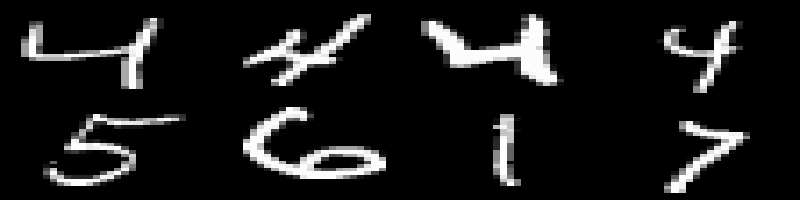

In [170]:
class_1 = Image.new('L', (800,200))

for i in range(0,4):
    class_1.paste(Image.fromarray(train_4[i]).resize([200,200]), (0+200*i,0))
class_1

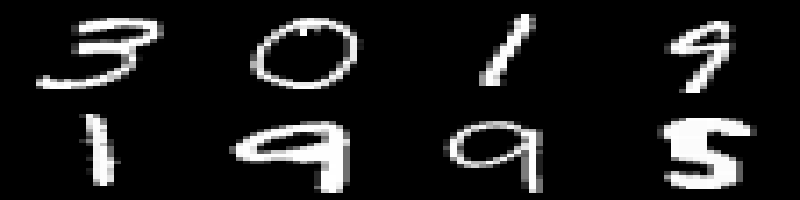

In [171]:
class_0 = Image.new('L', (800,200))

for i in range(0,4):
    class_0.paste(Image.fromarray(train_others[i]).resize([200,200]), (0+200*i,0))
class_0

#### Now we prepare to create a new dataset ####

In [172]:
new_MNIST_data = train_images_new, train_labels_new

In [173]:
new_MNIST_index = list(range(train_labels_new.shape[0]))
new_MNIST_dataset = Dataset(new_MNIST_index, batch_class=MnistBatch, preloaded=new_MNIST_data)
new_MNIST_dataset.cv_split([.8, .1, .1])

#### For example, let's use config for ResNet18 model from dataset.models.tf ####

In [174]:
config = dict(model=ResNet18) 

#### When config is defined, next step is to create a pipeline. ####


*Also we add to default pipeline rotation transform. Now each image rotate with probability 0.5 by angle = 180 degree.*

*As a result, the position of figure 4 will not be the same [before this (as you can see in sample pictures) all figures 4 were at the top]*

*Due to this trasformation we have complicated the learning process, adding variance in data*

In [176]:
train_template = (Pipeline(config=config)
                .init_variable('loss_history', init_on_each_run=list)
                .init_variable('current_loss', init_on_each_run=0)
                .shift_flattened()
                .init_model('dynamic', C('model'), 'conv_nn',
                            config={'inputs': dict(images={'shape': B('image_shape')},
                                                   labels={'classes': 2, 'transform': 'ohe', 'name': 'targets'}),
                                    'input_block/inputs': 'images',
                                    'output': dict(ops=['accuracy'])})
                .rotate(angle=180, p=0.5)  
                .to_array()
                .train_model('conv_nn', fetches='loss',
                                     feed_dict={'images': B('images'),
                                                'labels': B('labels')},
                             save_to=V('current_loss'))
                .update_variable('loss_history', V('current_loss'), mode='a')
)

#### Train the model ####
**Apply a dataset to a template pipeline to create a runnable pipeline:**

In [178]:
train_pipeline = (train_template << new_MNIST_dataset.train)

** Run the pipeline:**

In [179]:
BATCH_SIZE = 640
train_pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=True, bar=True)










  0%|          | 0/14 [00:00<?, ?it/s]








 14%|█▍        | 2/14 [00:31<03:11, 15.93s/it]








 21%|██▏       | 3/14 [00:57<03:28, 18.91s/it]








 29%|██▊       | 4/14 [01:22<03:26, 20.67s/it]








 36%|███▌      | 5/14 [01:47<03:16, 21.87s/it]








 43%|████▎     | 6/14 [02:14<03:07, 23.50s/it]








 50%|█████     | 7/14 [02:44<02:58, 25.46s/it]








 57%|█████▋    | 8/14 [03:15<02:43, 27.18s/it]








 64%|██████▍   | 9/14 [03:45<02:19, 27.88s/it]








 71%|███████▏  | 10/14 [04:16<01:55, 28.81s/it]








 79%|███████▊  | 11/14 [04:41<01:23, 27.87s/it]








 86%|████████▌ | 12/14 [05:09<00:55, 27.76s/it]








 93%|█████████▎| 13/14 [05:37<00:27, 27.81s/it]








100%|██████████| 14/14 [06:02<00:00, 27.15s/it]










#### Test the model ####

In [183]:
test_pipeline = (new_MNIST_dataset.test.p
                .import_model('conv_nn', train_pipeline)
                .init_variable('accuracy', init_on_each_run=list)
                .to_array()
                .predict_model('conv_nn', fetches='output_accuracy', 
                               feed_dict={'images': B('images'), 'labels': B('labels')},
                               save_to=V('accuracy'), mode='a')
                .run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=True, bar=True)
)











  0%|          | 0/1 [00:00<?, ?it/s]








100%|██████████| 1/1 [05:28<00:00, 328.62s/it]







  6%|▌         | 1/18 [19:17<5:27:58, 1157.54s/it]

ValueError: Cannot feed value of shape (640, 56, 28, 1) for Tensor 'ResNet18/inputs/images:0', which has shape '(?, 28, 28, 1)'

In [134]:
accuracy = np.array(test_pipeline.get_variable('accuracy')).mean()
print('Accuracy {:6.2f}'.format(accuracy))

Accuracy   0.99
